# Extract Mechanisms from Space

## Setup Environment

In [1]:
import os
import numpy as np
import pandas as pd

import scanpy as sc
import squidpy as sq
import liana as li
import matplotlib.pyplot as plt

In [2]:
import decoupler as dc

In [3]:
import plotnine as p9
from decoupler import p_adjust_fdr

In [4]:
import seaborn as sns

In [5]:
import sys
sys.path.append(os.path.join('..', 'spot_calling'))
from utils import load_prep_slide

In [6]:
data_dir = os.path.join('..', '..', 'data', 'heart_visium')
dataset_names = [f for f in os.listdir(data_dir) if f.endswith('.h5ad')]

In [7]:
metadata = pd.read_csv(os.path.join("..", "spot_calling", "visium_meta.csv")).set_index('slide_name')
group_dict = {'group_1': 'Myogenic', 'group_2':'Ischemic', 'group_3': 'Fibrotic'}
rename_dict = {'Myogenic': 'Myogenic \n (n=14)', 'Ischemic':'Ischemic \n (n=9)', 'Fibrotic': 'Fibrotic \n (n=5)'}
condition_key = 'patient_group'

In [8]:
metadata['patient_group'] = metadata['patient_group'].map(group_dict)

## Process Datasets

TODO: 
- Plot LR interactions for ischemia for main fig?
- Plot LR interactions for healthy in supps?
- Plot the interasting interactions locally
- Plot MISTy interactions as network
+ MOFAcellular plots (maybe in supps for LRs)
+ PyDeSeq for LR on single-cell
+ Do a network plot for up and down-regulated TFs/LRs

In [17]:
lrdatas = {}

for dataset_name in dataset_names:
   sample_id = metadata.loc[dataset_name.replace('.h5ad', ''), 'hca_sample_id']
   
   print(f"dataset_name: {dataset_name}; {sample_id}")
   adata = load_prep_slide(data_dir, dataset_name, add_sample_name=True)

   li.ut.spatial_neighbors(adata, bandwidth=150, set_diag=True, cutoff=0.1)

   adata.write_h5ad(os.path.join('results', 'processed', sample_id + '.h5ad'))

   li.mt.lr_bivar(adata,
                  function_name='cosine',
                  expr_prop=0.1,
                  n_perms=None, # NOTE, some bug here
                  use_raw=False,
                  add_categories=False,
                  # mask_negatives=True,
                  )
   lrdata = adata.obsm['local_scores']
   
   # save to folder
   lrdata.write_h5ad(os.path.join('results', 'lr', sample_id + '.h5ad'))

   lrdatas[sample_id] = lrdata

dataset_name: AKK001_157785.h5ad; 10X0027


KeyboardInterrupt: 

## Run NMF on the whole Dataset

In [18]:
features = pd.concat([lrdatas[dataset_name].var for dataset_name in lrdatas])
features['count'] = 1 
features = features.reset_index().groupby('interaction').sum().sort_values('count')

ValueError: No objects to concatenate

In [19]:
features['count'].hist(bins=30)

NameError: name 'features' is not defined

Keep features in at least X samples

In [13]:
features = features[features['count'] >= 10]

In [14]:
lrdata_all = sc.concat(lrdatas, join='outer', fill_value=0)
lrdata_all

AnnData object with n_obs × n_vars = 91205 × 1270
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche', 'n_genes'
    obsm: 'compositions', 'mt', 'spatial'

In [15]:
# subset to de features
lrdata_all = lrdata_all[:, features.index]
lrdata_all

View of AnnData object with n_obs × n_vars = 91205 × 613
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche', 'n_genes'
    obsm: 'compositions', 'mt', 'spatial'

## Run NMF

In [17]:
li.multi.nmf(lrdata_all, n_components=5, inplace=True, random_state=1337, max_iter=400, verbose=True, k_range=range(1, 21))

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.


In [18]:
lrdata_all.write_h5ad(os.path.join('results', 'lr', 'lrdata_all.h5ad'))

In [21]:
lr_loadings = li.ut.get_variable_loadings(lrdata_all, varm_key='NMF_H').set_index('index')

In [23]:
metadata = metadata.reset_index().set_index('hca_sample_id')

In [24]:
# save the NMF factors to the individual samples
for sample in lrdatas:
    labl = metadata.loc[sample, 'major_labl']
    lrdata = lrdatas[sample]
    # Get the NMF factors for the current sample from the full dataset
    temp = lrdata_all[lrdata_all.obs.index.isin(lrdata.obs.index), :]
    temp = temp[:, temp.var.index.isin(lrdata.var.index)]
    
    # extract NMF from obsm
    ad_nmf = sc.AnnData(X=temp.obsm['NMF_W'],
                        obs=temp.obs,
                        var=pd.DataFrame(index=lr_loadings.columns),
                        uns=lrdata.uns,
                        obsm={'spatial':temp.obsm['spatial']}
                        )
    ad_nmf.write_h5ad(os.path.join('results', 'nmf', sample))
    
    # plot
    # sq.pl.spatial_scatter(ad_nmf, color=[None, *lr_loadings.columns], cmap='viridis', title=f"{sample}:{labl}", vmin=0, size=1.4, img=True) #
    # plt.show() 

Check loadings

In [10]:
lrdata_all = sc.read_h5ad(os.path.join('results', 'lr', 'lrdata_all.h5ad'))

In [11]:
lr_loadings = li.ut.get_variable_loadings(lrdata_all, varm_key='NMF_H').set_index('index')

In [12]:
metadata = metadata.reset_index().set_index('hca_sample_id')

### Analyse Loadings

In [13]:
nmfdata = sc.AnnData(X=lrdata_all.obsm['NMF_W'].copy(),
                     obs=lrdata_all.obs,
                     var=pd.DataFrame(index=lr_loadings.columns),
                     uns=lrdata_all.uns,
                     obsm={'spatial':lrdata_all.obsm['spatial']}
                     )

In [14]:
indices = lrdata_all.obs.index
nmfdata.obs = nmfdata.obs.merge(metadata.reset_index(), left_on='sample', right_on='slide_name')
nmfdata.obs.index = indices

In [15]:
df = pd.DataFrame(lrdata_all.obsm['NMF_W'], columns=lr_loadings.columns, index=lrdata_all.obs.index)
df['sample'] = lrdata_all.obs['sample']
df = df.merge(metadata.reset_index(), left_on='sample', right_on='slide_name')

In [16]:
df.head()

,Factor1,Factor2,Factor3,Factor4,Factor5,sample,hca_sample_id,slide_name,patient,patient_region_id,patient_group,major_labl,batch
0,0.000000,0.061676,0.134935,0.156563,0.0,AKK001_157785,10X0027,AKK001_157785,P5,RZ/FZ_P5,Myogenic,FZ,10X
1,0.000798,0.091704,0.074106,0.352288,0.0,AKK001_157785,10X0027,AKK001_157785,P5,RZ/FZ_P5,Myogenic,FZ,10X
2,0.000000,0.097535,0.108173,0.281094,0.0,AKK001_157785,10X0027,AKK001_157785,P5,RZ/FZ_P5,Myogenic,FZ,10X
3,0.000000,0.099700,0.135927,0.271132,0.0,AKK001_157785,10X0027,AKK001_157785,P5,RZ/FZ_P5,Myogenic,FZ,10X
4,0.000000,0.064189,0.147847,0.190315,0.0,AKK001_157785,10X0027,AKK001_157785,P5,RZ/FZ_P5,Myogenic,FZ,10X


In [17]:
errors = lrdata_all.uns['nmf_errors']
rank = lrdata_all.uns['nmf_rank']

KeyError: 'nmf_errors'

In [18]:
errors

NameError: name 'errors' is not defined

NameError: name 'errors' is not defined

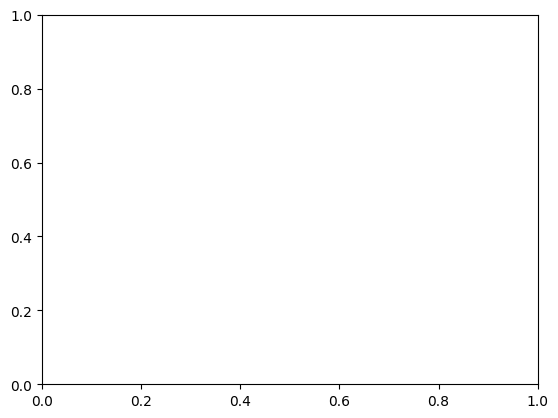

In [19]:
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the line and points
ax.plot(errors['k'], errors['error'], marker='o')

# Add the vertical line
ax.axvline(x=rank, linestyle='--', color='red')

# Set the x-ticks only if they are divisible by 5
ax.set_xticks([x for x in errors['k'].values if x % 5 == 0])

# Set the labels
ax.set_xlabel('Component number (k)')
ax.set_ylabel('Reconstruction error')

# Show the plot
plt.show()

In [20]:
import pandas as pd
from scipy.stats import fisher_exact, chi2_contingency

# Assuming df is your pandas DataFrame
factors = lr_loadings.columns
labels = df['patient_group'].unique()

# Initialize a DataFrame to store the results
odds = pd.DataFrame(columns=['factor', 'patient_group', 'odds_ratio', 'p_value'])

# Iterate over each factor and each label
for factor in factors:
    # Determine the top threshold
    threshold = df[factor].quantile(0.80)
    
    for label in labels:
        # Create a 2x2 contingency table
        top_and_label = sum((df[factor] >= threshold) & (df['patient_group'] == label))
        top_and_not_label = sum((df[factor] >= threshold) & (df['patient_group'] != label))
        not_top_and_label = sum((df[factor] < threshold) & (df['patient_group'] == label))
        not_top_not_label = sum((df[factor] < threshold) & (df['patient_group'] != label))
        
        contingency_table = [[top_and_label, top_and_not_label],
                             [not_top_and_label, not_top_not_label]]
        
        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)
        
        # Store results
        odds.loc[len(odds)] = [factor, label, odds_ratio, p_value]


In [21]:
# when odds = 0, p-value is 1
# odds['p_value'] = odds.apply(lambda x: 1 if x['odds_ratio'] == 0 else x['p_value'], axis=1)
# when odds is inf, set it to max

In [22]:
odds['log2_odds'] = np.log2(odds['odds_ratio'])

# if -inf, set to min (except -inf)
odds['log2_odds'] = odds.apply(lambda x: np.log2(1/1000) if x['log2_odds'] == -np.inf else x['log2_odds'], axis=1)
# if inf, set to max
odds['log2_odds'] = odds.apply(lambda x: np.log2(1000) if x['log2_odds'] == np.inf else x['log2_odds'], axis=1)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2


In [23]:
odds['adj_pval'] = p_adjust_fdr(odds['p_value'])

In [24]:
odds

,factor,patient_group,odds_ratio,p_value,log2_odds,adj_pval
0,Factor1,Myogenic,0.054980,0.000000e+00,-4.184950,0.000000e+00
1,Factor1,Ischemic,37.783072,0.000000e+00,5.239668,0.000000e+00
2,Factor1,Fibrotic,0.080284,0.000000e+00,-3.638749,0.000000e+00
3,Factor2,Myogenic,0.014686,0.000000e+00,-6.089457,0.000000e+00
4,Factor2,Ischemic,43.102343,0.000000e+00,5.429694,0.000000e+00
5,Factor2,Fibrotic,0.279495,0.000000e+00,-1.839107,0.000000e+00
6,Factor3,Myogenic,176.823782,0.000000e+00,7.466169,0.000000e+00
7,Factor3,Ischemic,0.013267,0.000000e+00,-6.236059,0.000000e+00
8,Factor3,Fibrotic,0.000000,0.000000e+00,-9.965784,0.000000e+00
9,Factor4,Myogenic,0.203704,0.000000e+00,-2.295455,0.000000e+00


Averages per slide

In [25]:
nmfdata.write_h5ad(os.path.join('results', 'nmf', 'nmfdata.h5ad'))

... storing 'sample' as categorical
... storing 'hca_sample_id' as categorical
... storing 'slide_name' as categorical
... storing 'patient' as categorical
... storing 'patient_region_id' as categorical
... storing 'patient_group' as categorical
... storing 'major_labl' as categorical
... storing 'batch' as categorical


In [26]:
nmfbulk = dc.get_pseudobulk(nmfdata,
                            sample_col='hca_sample_id',
                            groups_col=None,
                            mode='mean',
                            skip_checks=True,
                            min_cells=0,
                            min_counts=0,
                            min_prop=None,
                            min_smpls=None
                            )

In [27]:
nmfbulk.obs['patient_group'] = nmfbulk.obs['patient_group'].map(rename_dict)

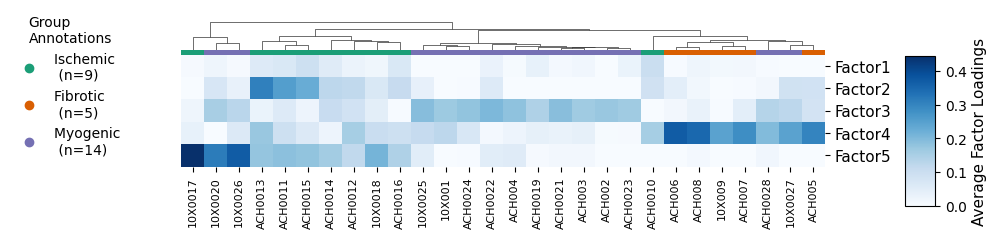

In [28]:

group_annotations = nmfbulk.obs['patient_group'].values
group_labels = set(group_annotations)
# import colour map Dark2 from seaborn
cmap = sns.color_palette('Dark2', n_colors=len(group_labels))
# get cmap values for each group annotation as hex
group_cmap = dict(zip(group_labels, cmap))
group_cols = [group_cmap[key] for key in group_labels]

chart = sns.clustermap(nmfbulk.X.T,
                       cmap='Blues',
                       cbar_kws={'orientation':'vertical'},
                       row_cluster=False,
                       col_cluster=True,
                       col_colors=[group_cmap[x] for x in group_annotations],
                       figsize=(10, 2.5),
                       xticklabels=nmfbulk.obs.index,
                       yticklabels=nmfbulk.var.index,
                       cbar_pos=None
                       )
# # rotate labels
chart.ax_heatmap.set_yticklabels(chart.ax_heatmap.get_ymajorticklabels(), rotation=0, fontdict={'fontsize':11})
chart.ax_heatmap.set_xticklabels(chart.ax_heatmap.get_xmajorticklabels(), fontsize=8)

# create separate axes for colorbar
cbar_ax = chart.fig.add_axes([.9, .2, .03, .6])  # x, y, width, height
cbar = plt.colorbar(chart.ax_heatmap.get_children()[0], cax=cbar_ax)
cbar.set_label('Average Factor Loadings', size=11, loc='center')  # Add title to the colorbar

# Create custom legend
legend_handles = []
for label, color in zip(group_labels, group_cols):
    legend_handles.append(plt.Line2D([0], [0], color=color, marker='o', linestyle='', label=label))

# Add legend
legend = plt.legend(handles=legend_handles, title='Group\nAnnotations', loc='upper right', frameon=False)

# Move the legend
chart_size = chart.ax_heatmap.get_position()
plt.setp(legend.get_title(), fontsize='medium')
legend.set_bbox_to_anchor((chart_size.x1-26.5, chart_size.y0+1))
plt.subplots_adjust(right=.82)
plt.show()

### Pathway Enrichment

In [29]:
lr_nmf = pd.DataFrame(lrdata_all.varm['NMF_H'], index=lrdata_all.var.index, columns=lr_loadings.columns)

In [30]:
lr_nmf.to_csv(os.path.join('results', 'lr_loadings.csv'))

In [31]:
lr_nmf.sort_values("Factor3", ascending=False).head(10)

,Factor1,Factor2,Factor3,Factor4,Factor5
S100A1^RYR2,0.000000,0.370084,4.325870,0.792014,0.752963
CALM1^RYR2,0.000000,0.474021,4.214680,0.852833,0.850760
CALM1^AQP1,3.047075,0.537919,3.516525,1.051037,0.784059
CALM3^RYR2,0.000000,0.647635,3.491405,0.653073,0.807243
VWF^ITGB1,4.983937,0.272209,3.485434,1.339155,0.995755
COL1A2^CD36,6.111463,0.131271,3.468524,1.580244,0.758838
LGALS1^ITGB1,5.798666,0.000000,3.427722,1.592952,1.275147
CD99^CD81,5.497098,0.145983,3.359840,1.571309,1.060976
C3^CD81,5.839156,0.000000,3.352849,1.007260,0.506887
TGM2^ITGB1,3.808039,0.336398,3.290815,1.310538,1.314167


Read NMF results

In [32]:
lr_nmf = pd.read_csv(os.path.join('results', 'lr_loadings.csv'), index_col=0)

In [33]:
# load PROGENy pathways
net = dc.get_progeny(organism='human', top=5000)
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [34]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
lr_progeny.head()

,source,interaction,weight
60,JAK-STAT,LGALS9^PTPRC,1.307807
1568,Androgen,SEMA4D^MET,-0.831693
1960,Androgen,HGF^MET,-1.288956
2352,Androgen,TIMP3^MET,-1.122612
3030,NFkB,SELE^CD44,3.332552


In [35]:
# run pathway enrichment analysis
estimate, pvals =  dc.run_ulm(lr_nmf.transpose(),
                              lr_progeny,
                              source="source",
                              target="interaction",
                              use_raw=False,
                              min_n=5)

In [36]:

# Pivot and merge data
estimate_long = estimate.melt(ignore_index=False, value_name='estimate', var_name='pathway').reset_index().rename(columns={'index':'factor'})
pvals_long = pvals.melt(ignore_index=False, value_name='pval', var_name='pathway').reset_index().rename(columns={'index':'factor'})
dc_res = estimate_long.merge(pvals_long, on=['factor', 'pathway'])

In [37]:
dc_res['adj_pval'] = p_adjust_fdr(dc_res['pval'])

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def create_heatmap(res, 
                   fill = 'estimate', 
                   index_key="factor",
                   column_key='pathway',
                   label='pval',
                   xlabel = None,
                   cbar_label=None,
                   max_value=None, significance_level=0.05,
                   figsize=(4, 3),
                   cmap='RdBu_r'):
    res = res.copy()
    if max_value is not None:
        res.loc[res[fill] > max_value, fill] = max_value
        res.loc[res[fill] < -max_value, fill] = -max_value
    
    res['significant'] = res[label].apply(lambda x: '*' if x < significance_level else '')
    sig_paths = res[res[label] <= significance_level][column_key].unique()

    # Filter for significant pathways
    filtered_data = res[res[column_key].isin(sig_paths)]
    # Create pivot table for heatmap
    heatmap_data = filtered_data.pivot(index=index_key, columns=column_key, values=fill)
    heatmap_data.sort_index(inplace=True, ascending=False)
    
    if max_value is None:
        norm = TwoSlopeNorm(vmin=-max_value, vcenter=0, vmax=max_value)
    else:
        norm = None
    
    # Plotting
    plt.figure(figsize=figsize)
    
    heatmap = plt.pcolormesh(heatmap_data, cmap=cmap, norm=norm)

    # Adding Text Annotations
    for y, row in enumerate(heatmap_data.index):
        for x, column in enumerate(heatmap_data.columns):
            plt.text(x + 0.5, y + 0.5,
                     filtered_data.loc[(filtered_data[index_key] == row) &
                                       (filtered_data[column_key] == column), 'significant'].values[0],
                     horizontalalignment='center', 
                     verticalalignment='center',
                     color='white',
                     fontstyle='oblique',
                     fontsize=20
                     )

    # Styling
    cbar = plt.colorbar(heatmap)
    plt.xticks(np.arange(0.5, len(heatmap_data.columns), 1), heatmap_data.columns, rotation=90, fontsize=14)
    plt.yticks(np.arange(0.5, len(heatmap_data.index), 1), heatmap_data.index, fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=15)
    if cbar_label is not None:
        cbar.set_label(cbar_label, size=15)
    
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

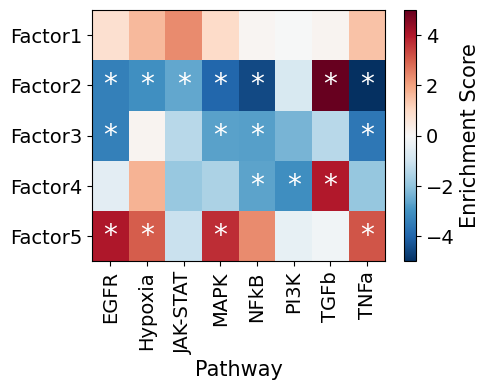

In [39]:
create_heatmap(dc_res, index_key="factor", column_key='pathway', label='adj_pval', xlabel="Pathway", cbar_label='Enrichment Score', significance_level=0.05, max_value=5, figsize=(5, 4))

In [40]:
# as category and alphabetical
odds['patient_group'] = odds['patient_group'].astype('category')
odds['patient_group'] = odds['patient_group'].cat.reorder_categories(sorted(odds['patient_group'].unique()))

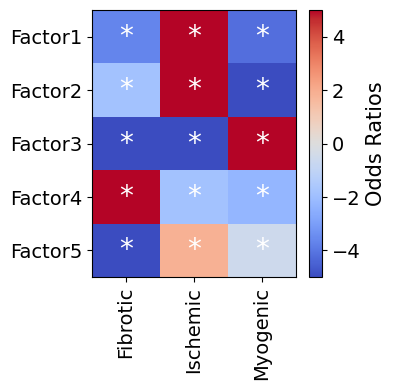

In [41]:
create_heatmap(odds, label='adj_pval', fill='log2_odds', index_key="factor", column_key='patient_group', cbar_label="Odds Ratios", significance_level=0.05, max_value=5, figsize=(4, 4), cmap='coolwarm')

In [42]:
from adjustText import adjust_text
def plot_lr_pairs(H,
                  fct,
                  label_fun, 
                  figsize=(6, 6),
                  method='average',
                  filename=None, 
                  adjust_text_kwargs={'arrowprops': dict(arrowstyle='->', color='darkred')}):
    lr_pairs = H[fct].reset_index()
    lr_pairs['rank'] = lr_pairs[fct].rank(ascending=False, method=method)
    lr_pairs['name'] = lr_pairs.apply(label_fun, axis=1)

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(lr_pairs['rank'], lr_pairs[fct], s=30, c='black')

    y_max = lr_pairs[fct].max()
    ax.set_ylim(lr_pairs[fct].min(), y_max + y_max * 0.1)

    ax.set_xlabel('Rank', fontsize=12)
    ax.set_ylabel(f'{fct} loadings', fontsize=12)
    plt.xticks(fontsize=12, rotation=90)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    texts = []
    for i, row in lr_pairs.iterrows():
        if row['name']:
            texts.append(ax.text(row['rank'], row[fct], row['name'], fontsize=11)) 

    adjust_text(texts, **adjust_text_kwargs)
    
    if filename:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()

In [1]:
plot_lr_pairs(lr_loadings, 
              fct='Factor4',
              label_fun=lambda x: x['index'] if x['rank'] <= 5 else None,
              figsize=(3.5, 3.5),
              adjust_text_kwargs={'arrowprops': dict(arrowstyle='-', color='darkred', lw=1.5), 
                                  'force_explode':(0.4, 0.4),
                                  'force_text':(0.5, 0.5),
                                #   'expand': (2, 1),
                                  }
              )

NameError: name 'plot_lr_pairs' is not defined

In [44]:
from scipy.stats import spearmanr

In [45]:
# pairwise correlations between factors
for i in range(0, nmfdata.shape[1]):
    for j in range(i+1, nmfdata.shape[1]):
        print(f"Factor{i+1} vs Factor{j+1}: {spearmanr(nmfdata.X[:, i], nmfdata.X[:,j])}")

Factor1 vs Factor2: SignificanceResult(statistic=0.4242636449936755, pvalue=0.0)
Factor1 vs Factor3: SignificanceResult(statistic=-0.3509930039250391, pvalue=0.0)
Factor1 vs Factor4: SignificanceResult(statistic=-0.24839097605168134, pvalue=0.0)
Factor1 vs Factor5: SignificanceResult(statistic=0.3062032890502803, pvalue=0.0)
Factor2 vs Factor3: SignificanceResult(statistic=-0.22648397055554154, pvalue=0.0)
Factor2 vs Factor4: SignificanceResult(statistic=0.14371269293667116, pvalue=0.0)
Factor2 vs Factor5: SignificanceResult(statistic=0.4745340312926439, pvalue=0.0)
Factor3 vs Factor4: SignificanceResult(statistic=-0.45337648818186993, pvalue=0.0)
Factor3 vs Factor5: SignificanceResult(statistic=-0.12382324460404322, pvalue=2.1419580162412656e-308)
Factor4 vs Factor5: SignificanceResult(statistic=-0.3059756091175661, pvalue=0.0)


Select Spatially-interesting LRs

In [46]:
lr_nmf = pd.read_csv(os.path.join('results', 'lr_loadings.csv'), index_col=0)
# pivot longer
lr_nmf = lr_nmf.reset_index().melt(id_vars='index', var_name='factor', value_name='loading')

# groupby each factor and filter to the Xth quantile
lr_nmf = lr_nmf.groupby('factor').apply(lambda x: x[x['loading'] >= x['loading'].quantile(0.95)])
lr_nmf.reset_index(drop=True, inplace=True)

# separete by ^ into ligand and receptor
lr_nmf['ligand'] = lr_nmf['index'].str.split('^').str[0]
lr_nmf['receptor'] = lr_nmf['index'].str.split('^').str[1]
resource = lr_nmf[['ligand', 'receptor']].drop_duplicates()

In [47]:
resource.to_csv(os.path.join("results", 'lr_pairs.csv'), index=False)